In [ ]:
!pip install -qU langchain langchain-core langchain-community langchain-experimental langchain-groq langgraph langsmith

# Environment Setup

In [ ]:
import os
from google.colab import userdata

os.environ['GROQ_API_KEY'] = userdata.get('GROQ_API_KEY')
os.environ['LANGSMITH_API_KEY'] = userdata.get('LANGSMITH_API_KEY')

# Set up Langsmith project

In [ ]:
os.environ['LANGCHAIN_API_KEY'] = userdata.get('LANGSMITH_API_KEY')
os.environ['LANGSMITH_TRACING'] = "true"
os.environ["LANGCHAIN_PROJECT"] = "MultiAgentChatbot"

# Set up the LLM model

In [ ]:
from langchain_groq import ChatGroq

llm = ChatGroq(
    model = 'mixtral-8x7b-32768',
    temperature=0.0
)

# Setting up the tools

[wikipedia](https://python.langchain.com/docs/how_to/tools_builtin/)

In [ ]:
!pip install -qU langchain-community wikipedia

In [ ]:
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper

In [ ]:
wiki_api_wrapper = WikipediaAPIWrapper(
    top_k_results = 1,
    doc_content_chars_max=100
)

wiki_tool = WikipediaQueryRun(api_wrapper = wiki_api_wrapper)

In [ ]:
print(wiki_tool.invoke({"query": "langchain"}))

Page: LangChain
Summary: LangChain is a framework designed to simplify the creation of applications 


[Duck Duck Go](https://python.langchain.com/docs/integrations/tools/ddg/)

In [ ]:
%pip install -qU duckduckgo-search langchain-community

In [ ]:
from langchain_community.utilities import DuckDuckGoSearchAPIWrapper
from langchain_community.tools import DuckDuckGoSearchResults

search_wrapper = DuckDuckGoSearchAPIWrapper(max_results=2)

search_tool = DuckDuckGoSearchResults(api_wrapper=search_wrapper, source="news")

In [ ]:
print(search_tool.invoke({"query": "openai"}))

snippet: Greater productivity. Endless inspiration. Try ChatGPT. We believe our research will eventually lead to artificial general intelligence, a system that can solve human-level problems. Building safe and beneficial AGI is our mission., title: OpenAI, link: https://openai.com/, snippet: OpenAI aims to create safe and beneficial artificial general intelligence (AGI) that can benefit all of humanity. Learn about their mission, vision, research, products, and careers., title: About - OpenAI, link: https://openai.com/about/, snippet: The most powerful platform for building AI products. Build and scale AI experiences powered by industry-leading models and tools. Start building View API pricing. Flagship models. GPT-4o. Our high-intelligence flagship model for complex, multi-step tasks. Text and vision. 128k context length. Input: $5 | Output: $15 . per 1M tokens. Learn more., title: API platform | OpenAI, link: https://openai.com/api/, snippet: DALL·E 2 can create original, realistic i

[ArXiv](https://python.langchain.com/docs/integrations/tools/arxiv/)

In [ ]:
%pip install --upgrade --quiet  langchain-community arxiv

In [ ]:
from langchain_community.utilities import ArxivAPIWrapper
from langchain_community.tools import ArxivQueryRun

arxiv_wrapper = ArxivAPIWrapper(op_k_results = 3)
arxiv_tool = ArxivQueryRun(api_wrapper = arxiv_wrapper)

In [ ]:
print(arxiv_tool.invoke({"query": "Attention is all you need"}))

Published: 2024-07-22
Title: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models
Authors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini
Summary: The inference demand for LLMs has skyrocketed in recent months, and serving
models with low latencies remains challenging due to the quadratic input length
complexity of the attention layers. In this work, we investigate the effect of
dropping MLP and attention layers at inference time on the performance of
Llama-v2 models. We find that dropping dreeper attention layers only marginally
decreases performance but leads to the best speedups alongside dropping entire
layers. For example, removing 33\% of attention layers in a 13B Llama2 model
results in a 1.8\% drop in average performance over the OpenLLM benchmark. We
also observe that skipping layers except the latter layers reduces performances
for more layers skipped, except for skipping the attention layers.

Published: 2021-0

# Toolkit

In [ ]:
toolkit = [wiki_tool, search_tool, arxiv_tool]

In [ ]:
llm_with_tools = llm.bind_tools(
    tools = toolkit
)

# Langgraph

In [ ]:
from typing import Annotated, Literal, TypedDict
from langchain_core.tools import tool
from langgraph.graph import END, START, StateGraph, MessagesState
from langgraph.prebuilt import ToolNode, tools_condition

# State == MessagesState

In [ ]:
# from langgraph.graph.message import add_messages
# class State(TypedDict):
#   '''
#     Messages have the type "list". The `add_messages` function
#     in the annotation defines how this state key should be updated
#     (in this case, it appends messages to the list, rather than overwriting them)
#   '''
#   messages:Annotated[list, add_messages]


In [ ]:
# Start the process of building the graph
graph_builder = StateGraph(MessagesState)
# graph_builder = StateGraph(State)

# Building Chatbot

After building the graph, our graph should interact with the LLM.

Note: Anytime we create a Node, it need to take the State paremeter of State(class). This is because, based on the statemessage, the state management should keep changing.

In [ ]:
def chatbot(state:MessagesState):
  '''
    return: After any response from the chatbot, we need to update the message variable.
    llm_with_tools invoke: Specifically invoke from the state message, which will hold the user query
  '''

  return {'messages': [llm_with_tools.invoke(state['messages'])]}

# Add node to the chatbot

In [ ]:
graph_builder.add_node("chatbot", chatbot)

## Add the tool node

In [ ]:
tools_node = ToolNode(tools=toolkit)
# Make sure the name of the node is always tools
graph_builder.add_node("tools", tools_node)

# Add edges

In [ ]:
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

Chatbot should interact with the tool.

The chatbot should interact with the tools based on some conditions, This interaction will be bi-directional.

**So for bi-directional interactions, we need to use Conditional Edges.**


```
from langgraph.prebuilt import tools_condition
```

tools_condition: Creates the bidirectional interaction possible


In [ ]:
graph_builder.add_conditional_edges("chatbot", tools_condition)
graph_builder.add_edge("tools", "chatbot")

# Compile Graph

In [ ]:
graph = graph_builder.compile()

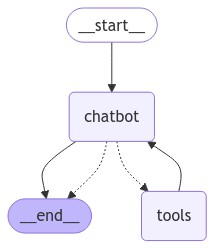

In [ ]:
from IPython.display import Image, display
try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
  pass

# Run

In [ ]:
input = "What is pythagoras theorem"

events = graph.stream(
    {"messages": [('user',input)]},
    stream_mode='values'
    )


for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is pythagoras theorem
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_9rh8)
 Call ID: call_9rh8
  Args:
    query: Pythagorean theorem
================================= Tool Message =================================
Name: wikipedia

Page: Pythagorean theorem
Summary: In mathematics, the Pythagorean theorem or Pythagoras' theorem is
================================== Ai Message ==================================

The Pythagorean theorem, also known as Pythagoras' theorem, states that in a right-angled triangle, the square of the length of the hypotenuse (the side opposite the right angle) is equal to the sum of the squares of the lengths of the other two sides. This can be written as: a² + b² = c², where c represents the length of the hypotenuse, and a and b represent the lengths of the other two sides. This theorem is a fundamental princi

In [ ]:
input = "What is current temperature in Michigan"

events = graph.stream(
    {"messages": [('user',input)]},
    stream_mode='values'
    )


for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is current temperature in Michigan
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_results_json (call_y6yz)
 Call ID: call_y6yz
  Args:
    query: current temperature in Michigan
================================= Tool Message =================================
Name: duckduckgo_results_json

snippet: Current conditions at Ann Arbor, Ann Arbor Municipal Airport (KARB) Lat: 42.22°NLon: 83.74°WElev: 837ft. Fair. 79°F. 26°C. Humidity: 52%: Wind Speed: E 10 mph: ... Hourly Weather Forecast. National Digital Forecast Database. High Temperature. Chance of Precipitation. ACTIVE ALERTS Toggle menu. Warnings By State; Excessive Rainfall;, title: National Weather Service, link: https://forecast.weather.gov/zipcity.php?inputstring=Ann+Arbor,MI&Go2=Go, snippet: Current conditions at Coleman A Young Municipal Airport (KDET) Lat: 42.41°NLon: 83.01°WElev: 620ft

In [ ]:
input = "What wrote Transformer is all you need paper?"

events = graph.stream(
    {"messages": [('user',input)]},
    stream_mode='values'
    )


for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What wrote Transformer is all you need paper?
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_results_json (call_cht6)
 Call ID: call_cht6
  Args:
    query: Transformer is all you need paper
================================= Tool Message =================================
Name: duckduckgo_results_json

snippet: Eight names are listed as authors on "Attention Is All You Need," a scientific paper written in the spring of 2017. They were all Google researchers, though by then one had left the company., title: 8 Google Employees Invented Modern AI. Here's the Inside Story, link: https://www.wired.com/story/eight-google-employees-invented-modern-ai-transformers-paper/, snippet: Published Aug 19, 2024. + Follow. Transformers have played a major role in the development of Generative AI as we know today. The "Attention Is All You Need" paper is one of the 